<a href="https://colab.research.google.com/github/fridapp09/GAN-generateFaces/blob/main/166520_GAN_GenerateFaces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
# Import the necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

In [29]:
from google.colab import drive

# Mount the Google Drive
drive.mount('/content/gdrive', force_remount=True)

# Folder path containing the images
data_dir = '/content/gdrive/MyDrive/Dataset/Imagenes/'

Mounted at /content/gdrive


In [30]:
#!unzip '/content/gdrive/MyDrive/Dataset/Imagenes/CelebFaces3200.zip' -d '/content/gdrive/MyDrive/Dataset/Imagenes/'

In [31]:
# Configure the image generator
datagen = ImageDataGenerator(rescale=1./255)

# Load the images from the folder
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode=None,
    color_mode='rgb'
)

Found 3200 images belonging to 1 classes.


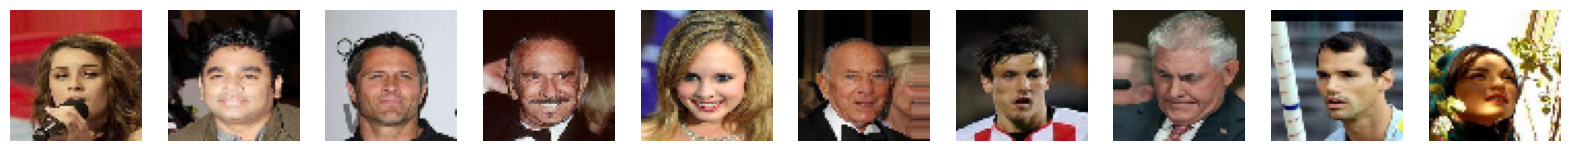

In [80]:
# Get a batch of images from the training generator
x_batch = train_generator.next()

# Display the first 10 images in the batch
fig, axs = plt.subplots(1, 10, figsize=(20, 5))
axs = axs.ravel()

for i in range(10):
    axs[i].imshow(x_batch[i])
    axs[i].axis('off')

plt.show()

In [33]:
# Define the path where the checkpoints will be saved
checkpoint_dir = '/content/gdrive/MyDrive/Dataset/Imagenes/'

# Define how often you want to save the model (every 20 epochs)
checkpoint_frequency = 20

# Create the ModelCheckpoint object
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_dir, 
                                      save_freq=checkpoint_frequency,
                                      save_best_only=True,
                                      save_weights_only=True,
                                      verbose=1)

In [34]:
# Define the architecture of the generator
def build_generator():
  model = Sequential()
  model.add(layers.Dense(128 * 8 * 8, activation="relu", input_dim=100))
  model.add(layers.Reshape((8, 8, 128)))

  model.add(layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same", activation="relu"))
  model.add(layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same", activation="relu"))
  model.add(layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same", activation="relu"))
  model.add(layers.Conv2D(3, kernel_size=3, padding="same", activation="sigmoid"))

  return model

In [35]:
# Define the architecture of the discriminator
def build_discriminator():
  model = Sequential()
  model.add(layers.Conv2D(64, kernel_size=3, strides=2, input_shape=(64, 64, 3), padding="same"))
  model.add(layers.LeakyReLU(alpha=0.2))
  
  model.add(layers.Conv2D(128, kernel_size=3, strides=2, padding="same"))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU(alpha=0.2))
  
  model.add(layers.Conv2D(256, kernel_size=3, strides=2, padding="same"))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU(alpha=0.2))
  
  model.add(layers.Flatten())
  model.add(layers.Dense(1, activation="sigmoid"))

  return model

In [37]:
# Define the generator loss function
def generator_loss(fake_output):
  return tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)

# Define the discriminator loss function
def discriminator_loss(real_output, fake_output):
  real_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output)
  fake_loss = tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

# Define the optimizers
generator_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_optimizer= Adam(learning_rate=0.0002, beta_1=0.5)

In [38]:
# Define the generator training function
@tf.function
def train_generator_step(generator, discriminator):
  with tf.GradientTape() as tape:
    # Generate fake images
    noise = tf.random.normal([32, 100])
    fake_images = generator(noise)
    
    # Calculate the generator loss
    fake_output = discriminator(fake_images)
    loss = generator_loss(fake_output)
    
    # Calculate the gradients and apply them to the model
    gradients = tape.gradient(loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients, generator.trainable_variables))
    
    return loss

# Define the discriminator training function
@tf.function
def train_discriminator_step(generator, discriminator, real_images):
  with tf.GradientTape() as tape:
    # Generate fake images
    noise = tf.random.normal([32, 100])
    fake_images = generator(noise)

    # Calculate the discriminator loss for real and fake images
    real_output = discriminator(real_images)
    fake_output = discriminator(fake_images)
    loss = discriminator_loss(real_output, fake_output)

    # Calculate the gradients and apply them to the model
    gradients = tape.gradient(loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients, discriminator.trainable_variables))

    return loss

In [39]:
# Train the GAN

# Define the generator and discriminator
generator = build_generator()
discriminator = build_discriminator()

# Define the number of epochs and the batch size
epochs = 100
batch_size = 32

# Define lists to store the loss of the generator and discriminator in each epoch
generator_loss_list = []
discriminator_loss_list = []

# Iterate over each epoch
for epoch in range(epochs):
  # Define the loss of the generator and discriminator for this epoch
  generator_loss_epoch = 0
  discriminator_loss_epoch = 0
  
  # Iterate over each batch of the training set
  for i in range(len(train_generator)):
    # Get a batch of real images
    real_images = train_generator.next()

    # Build the optimizer with the full list of trainable variables
    discriminator_optimizer.build(discriminator.trainable_variables)

    # Train the discriminator
    discriminator_loss_batch = train_discriminator_step(generator, discriminator, real_images)
    discriminator_loss_epoch += discriminator_loss_batch
    
    # Train the generator every two steps of the discriminator
    if i % 2 == 0:
      generator_loss_batch = train_generator_step(generator, discriminator)
      generator_loss_epoch += generator_loss_batch
      
      # Calculate the average loss of the generator and the discriminator
      generator_loss_epoch /= len(train_generator) // 2
      discriminator_loss_epoch /= len(train_generator)
      
      # Add generator and discriminator loss to the corresponding lists
      generator_loss_list.append(generator_loss_epoch)
      discriminator_loss_list.append(discriminator_loss_epoch)
      
      # Print the loss of the generator and discriminator in this epoch
      print("Epoch {}/{}: Generator loss: {:.4f}, Discriminator loss: {:.4f}".format(epoch+1, epochs, generator_loss_epoch.numpy().mean(), discriminator_loss_epoch.numpy().mean()))

Epoch 1/100: Generator loss: 0.0144, Discriminator loss: 0.0138
Epoch 1/100: Generator loss: 0.0156, Discriminator loss: 0.0270
Epoch 1/100: Generator loss: 0.0160, Discriminator loss: 0.0261
Epoch 1/100: Generator loss: 0.0159, Discriminator loss: 0.0251
Epoch 1/100: Generator loss: 0.0195, Discriminator loss: 0.0231
Epoch 1/100: Generator loss: 0.0206, Discriminator loss: 0.0207
Epoch 1/100: Generator loss: 0.0168, Discriminator loss: 0.0185
Epoch 1/100: Generator loss: 0.0299, Discriminator loss: 0.0186
Epoch 1/100: Generator loss: 0.0273, Discriminator loss: 0.0164
Epoch 1/100: Generator loss: 0.0176, Discriminator loss: 0.0200
Epoch 1/100: Generator loss: 0.0256, Discriminator loss: 0.0264
Epoch 1/100: Generator loss: 0.0209, Discriminator loss: 0.0278
Epoch 1/100: Generator loss: 0.0216, Discriminator loss: 0.0253
Epoch 1/100: Generator loss: 0.0240, Discriminator loss: 0.0201
Epoch 1/100: Generator loss: 0.0312, Discriminator loss: 0.0148
Epoch 1/100: Generator loss: 0.0336, Dis

1/1 [==============================] - 0s 257ms/step


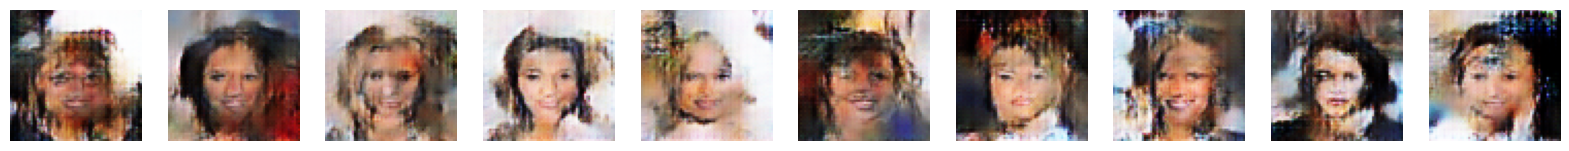

In [85]:
# Generate 10 random images
ruido = np.random.normal(0, 1, size=[10, 100])
generated_images = generator.predict(ruido)

# Display the images generated
fig, axs = plt.subplots(1, 10, figsize=(20, 5))
axs = axs.flatten()

for i in range(10):
    axs[i].imshow(generated_images[i])
    axs[i].axis('off')

plt.show()